# Vegetable classifier using Deep learning 

<b>Author</b> : <a>Sriganesh Venugopal(sriganesh.venugopal@outlook.com)</a>

## Introduction:

In this notebook, we will go through
* Preprocess and build data required for tarining
* Use transfer learning to train a vegetable classifier model based on resnet architecture
* Interpret the results
* Export the model as pickle file
* Load the model and use it for single and batch predictions

Note: At the end of notebook, there are several supporting fuctions which will be used during model building and evaluation

## Step 1 - Mount google drive

In [1]:
# Mount google drive to access images for train\valid\test are available 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Step 2 - Build the data required for training and validation

In [1]:
#----------------------------------
#import required packages\libraries
#----------------------------------
from fastai.vision import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
import pandas as pd
import numpy as np
from PIL import Image
import os, os.path
import warnings
warnings.filterwarnings("ignore")

#----------------------------------------------------------------------------
#Required for windows machine to specify the path where packages are located.
#----------------------------------------------------------------------------
import sys
sys.path.append('C:\\Users\\sriga\\Desktop\\ML\\Springboard\\vegetable-classifier\\vegclassify')

import build_data



In [2]:
#------------------------------------------------
# Define the images source path and valid classes
#------------------------------------------------
imgpath = Path('C:\\Users\\sriga\\Desktop\\ML\\Springboard\\vegetable-classifier\\exploration\\Data\\images')
classes = ['ash gourd','asparagus','bamboo shoot','basil','beans','beetroot','bitter gourd','black raddish','bottle gourd','brinjal','broccoli','cabbage','capsicum','carrot',
           'cauliflower','celeriac','chayote','chilli','chinese artichokes','cluster beans','coconut','colocasia','coriander leaves','corn','cucumber','curry leaves','dill',
           'drumstick','dulse','elephant yam','fenugreek leaves','fiddleheads','flat beans','garlic','ginger','gooseberry','green mango','ivy gourd','kohlrabi','lemon','lime',
           'long beans','lotus root','mint','mushroom','nopal','oca','okra','onion','peas','plantain','plantain flower','plantain stem','potato','pumpkin','ramps','red chilli',
           'red raddish','ridge gourd','romanesco','shallots','snake gourd','sweet potato','tapioca','tomato','turnip','white onion','white raddish','yam', 'zuchini']


In [4]:
#------------------------------------------------------------------------------------------
#validate whether an image is valid i.e. can it be opened as valid image. If not delete it.
#------------------------------------------------------------------------------------------
build_data.validate_images(imgpath,classes)

Validation of images complete...


In [5]:
#------------------------------------------------------------------------------------------
# Preprocess and build data. Here label is derived from the folder name. 
# Unfortunately the split between training and testing is 80:20 on overall data and not at 
# each class level. Hence classes with less images may not be picked for validation
# reference - https://forums.fast.ai/t/stratified-labels-sampling/28002/8
#------------------------------------------------------------------------------------------
databunch = build_data.build_data_from_folder(imgpath,split=0.2,size=224,bs=16)

starting to build data from folder...
returning the data built from folder...


In [7]:
#------------------------------------------------------------------------------------------
# As a workaround, we need to build the data somewhere else outside and pass it to fast ai 
# library. I have used scikit learn library to create the train test split in a stratified 
# way. It has two steps 1) create a dataframe from databunch 2) Pass that dataframe to 
# scikit learn train_test_split and with an option to strtify the results. The result will
# be trainX, validX, trainY, validY dataframes
#-------------------------------------------------------------------------------------------
result = build_data.build_df_from_databunch(databunch)
(trainX, validX, trainY, validY) = train_test_split(result['x'],result['y'],stratify=result['y'],test_size=0.2, random_state=42)

starting to build dataframe from databunch...
returning the dataframe back to main...


In [9]:
#-------------------------------------------------------------------------------------------
# Now we have stratified train and validation data as dataframe. But fast ai needs them as 
# databunch. Inorder to build the databunch out of data frame, fast ai needs to know which 
# records needs to be considered for training v/s validation. We already have built seperate
# train and valid dataframes in above step. We just need to add one more label to dataframe 
# to indicate which record need to be used for validation. The final_df is a dataframe that
# has both training and validation data combined, but now with a label indicating which rows
# are validatoin records v/s training records. 
#-------------------------------------------------------------------------------------------
final_df = build_data.build_stratified_data(trainX,trainY,validX,validY)

starting to build stratified classes
returning the final dataframe...


In [11]:
#-------------------------------------------------------------------------------------------
# The final step is to build the fast ai databunch from the dataframe.
#-------------------------------------------------------------------------------------------
final_databunch = build_data.build_data_from_df(final_df,imgpath,size=224,bs=16)
final_databunch.c, len(final_databunch.train_ds), len(final_databunch.valid_ds)
#-------------------------------------------------------------------------------------------

starting to build databunch from df...
returning the databunch built from df...


(70, 7283, 1821)

## Step 3 -  Create a learner

In [13]:
#---------------------------------------------------------------------------------------------
# Create a cnn learner based on resnet34 architecture. Metrics are error rate, accuracy 
# (top 1 rank),top_3_accuracy, top_k_accuracy (top 5 rank)
#---------------------------------------------------------------------------------------------
top_3_accuracy = partial(top_k_accuracy, k=3)
learn = cnn_learner(final_databunch, models.resnet34, metrics=[error_rate,accuracy,top_3_accuracy,top_k_accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


## Step 4 -  Train

In [16]:
#--------------------------------------
# Initially start training with 4 epoch
#--------------------------------------
train(learn,epoch=4)
learn.save("Feb4-stage-1")

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.905349,1.150638,0.323544,0.676456,0.870085,0.920856,30:29
1,1.610375,0.887855,0.258337,0.741663,0.910403,0.951717,02:12
2,1.110096,0.611276,0.181185,0.818815,0.944251,0.972623,02:13
3,0.859818,0.546317,0.164261,0.835739,0.953708,0.976108,02:11


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


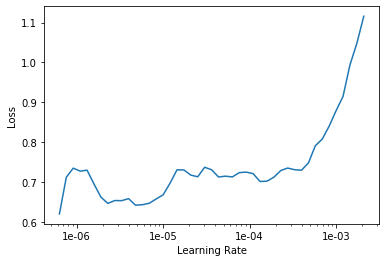

In [18]:
#-----------------------------------------------------------
# To improve results, we try to find a better learning rate. 
#-----------------------------------------------------------
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [21]:
#---------------------------------------------------------------------
# Retrain with more epoch and better learning. In below metrics, first
# top_k_accuracy is top 3 and next is top 5 accuracy
#---------------------------------------------------------------------
train(learn,epoch=20,maxlr=slice(1e-06,1e-04))
learn.save("Feb4-stage-2")

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,top_k_accuracy,time
0,0.797575,0.541867,0.160279,0.839721,0.953708,0.975610,02:12
1,0.734044,0.526823,0.159283,0.840717,0.956695,0.976605,02:09
2,0.737744,0.510617,0.154803,0.845197,0.958188,0.979094,02:07
3,0.693999,0.495429,0.149826,0.850174,0.961672,0.978099,02:08
4,0.632125,0.491512,0.143355,0.856645,0.964161,0.980587,02:08
5,0.629192,0.470832,0.137880,0.862120,0.964161,0.979094,02:09
6,0.527988,0.450460,0.138875,0.861125,0.966650,0.983076,02:08
7,0.506025,0.436837,0.133897,0.866103,0.965157,0.981583,02:08
8,0.460883,0.424345,0.121951,0.878049,0.967646,0.980090,02:09
9,0.458444,0.424277,0.120956,0.879044,0.968143,0.983574,02:08


## Step 5 -  Interpret results

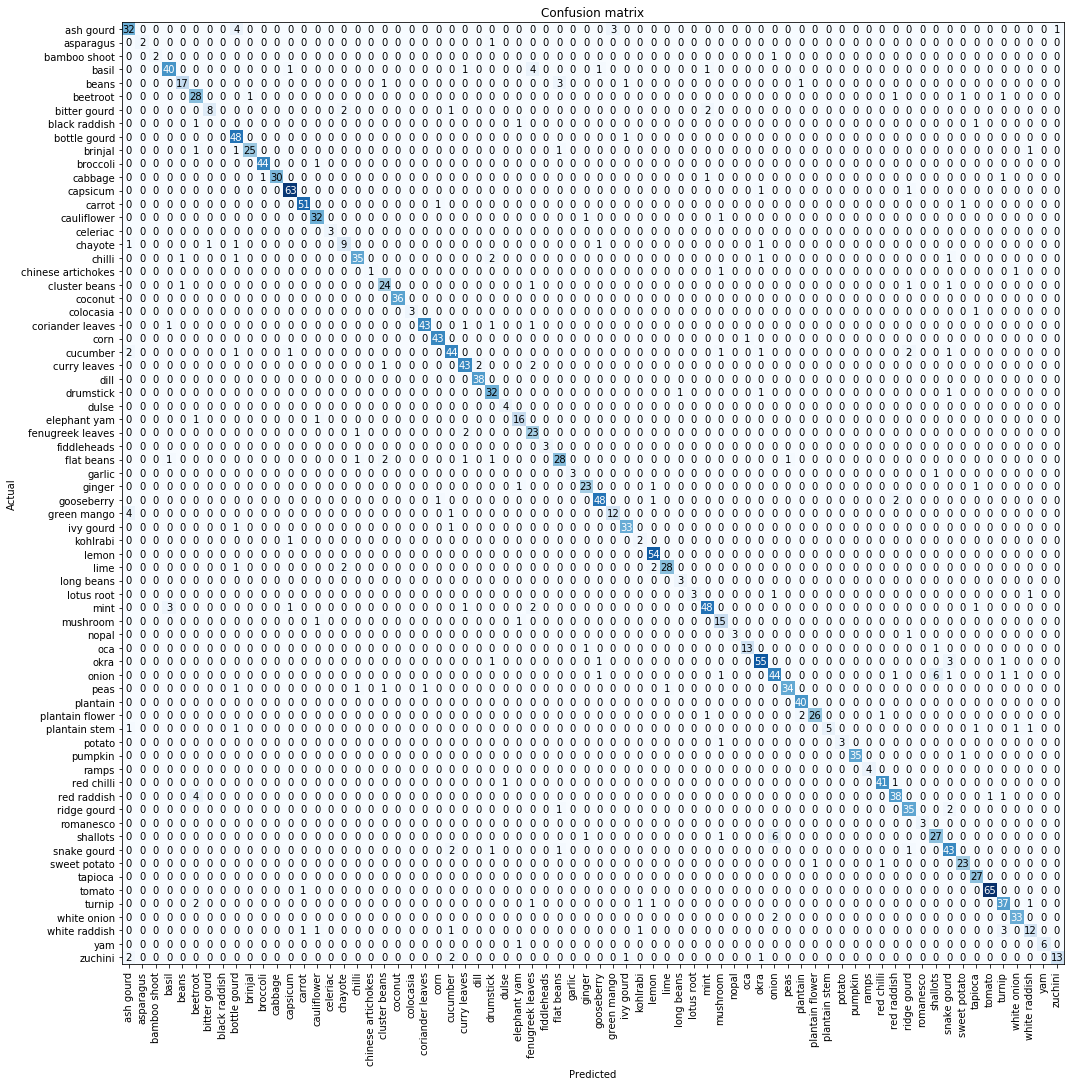

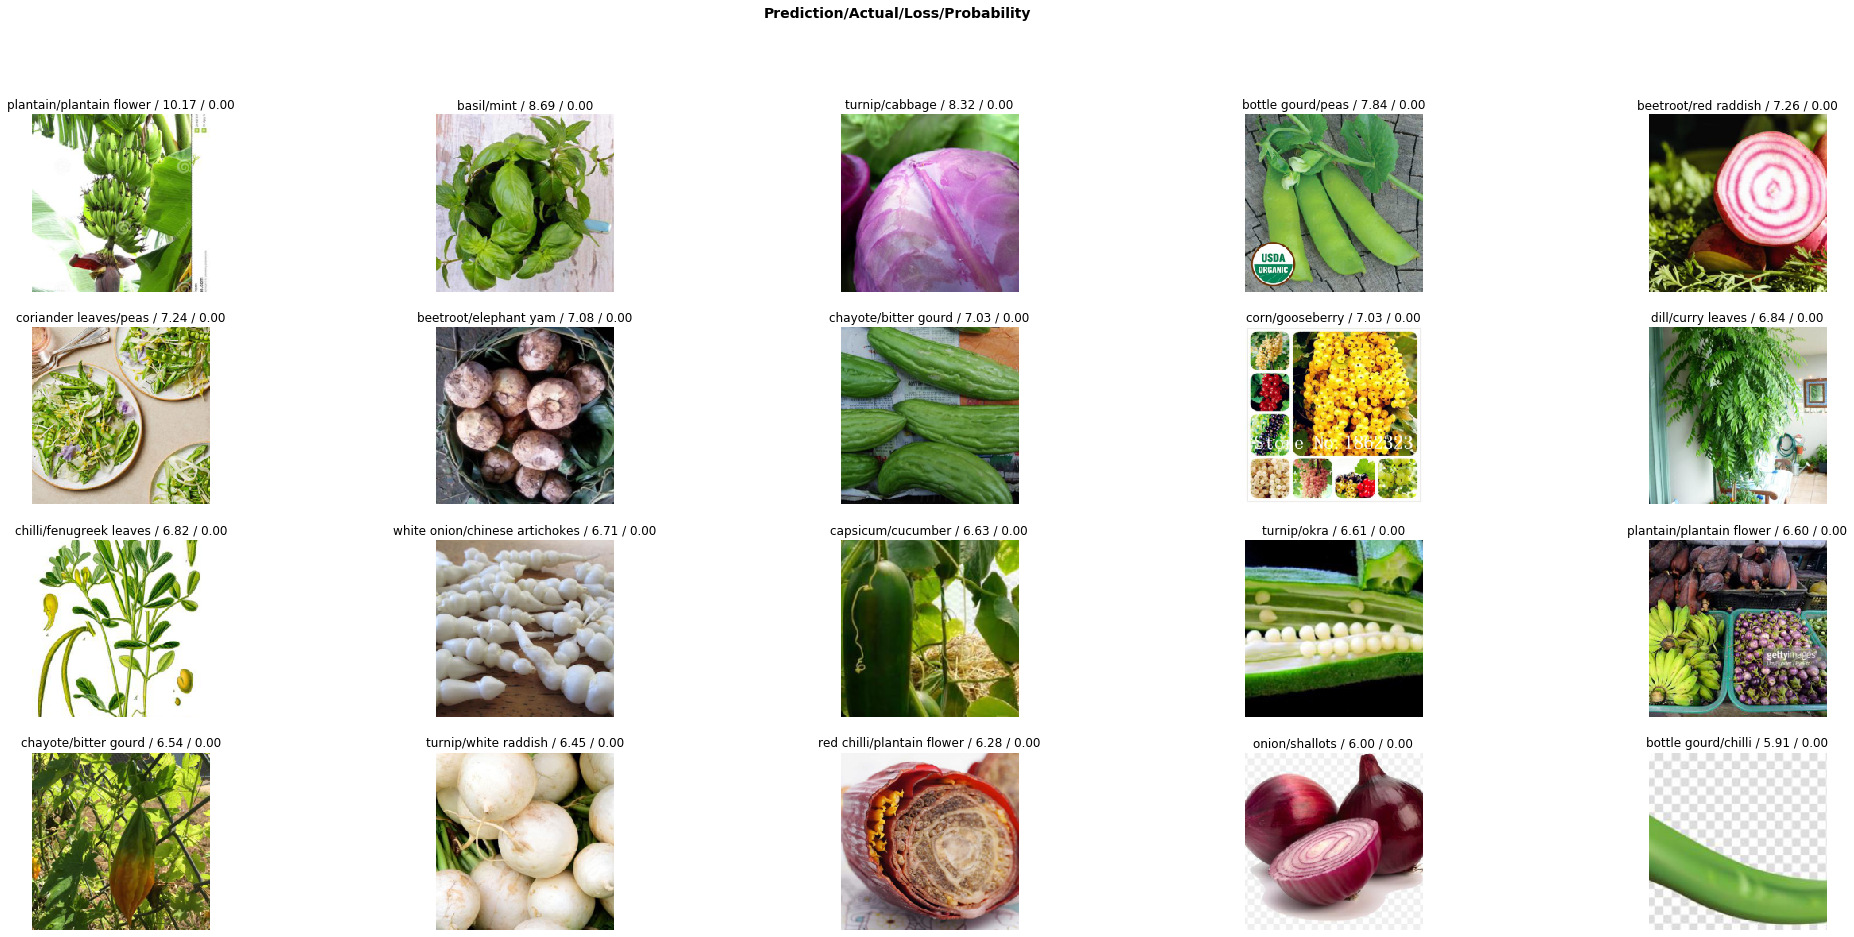

In [26]:
#--------------------------------------------------------------------
# Interpret the results. Look at confusion matrix and top losses plot
#--------------------------------------------------------------------
interpret_results(learn)


In [32]:
#------------------------------
# Check accuracy by each class
#------------------------------
pd.options.display.max_rows = 100
accuracy_by_category()

,class,total_correct,total,accuracy
0,ash gourd,32,40,80.00
1,asparagus,2,3,66.67
2,bamboo shoot,2,3,66.67
3,basil,40,48,83.33
4,beans,17,23,73.91
5,beetroot,28,32,87.50
6,bitter gourd,8,13,61.54
7,black raddish,0,3,0.00
8,bottle gourd,48,49,97.96
9,brinjal,25,29,86.21


## Step 6 -  Export the final model

In [0]:
learn.export()

## Step 7 -  Load the model and Predict


> ### Single Prediction











In [0]:
#------------------------------------
# Load the learner saved in last step
#------------------------------------
learn = load_learner("/content/drive/My Drive/images")

In [35]:
#----------------------------------------------------------------------------------------------------------
# As a test load one image and predict. The results shows the category label followed by tensor information
#----------------------------------------------------------------------------------------------------------
img = final_databunch.train_ds[0][0]
learn.predict(img)

(Category ash gourd,
 tensor(0),
 tensor([9.9390e-01, 1.7454e-06, 1.7014e-06, 1.1538e-05, 6.9057e-07, 8.8356e-07,
         7.7904e-06, 1.0517e-05, 1.0700e-04, 4.6038e-06, 2.5751e-05, 1.1987e-05,
         3.0105e-05, 8.3853e-07, 3.9033e-07, 1.0964e-06, 1.0305e-05, 7.9613e-07,
         9.8858e-07, 5.8311e-07, 1.4065e-05, 5.2397e-06, 3.6837e-06, 2.6575e-06,
         6.2539e-05, 2.5858e-05, 2.8119e-04, 1.0491e-07, 2.3921e-07, 7.8473e-07,
         2.5748e-06, 2.8458e-06, 7.0571e-06, 4.4328e-06, 2.4363e-08, 1.6322e-05,
         5.0063e-03, 1.5430e-06, 3.1585e-06, 6.3417e-06, 6.0676e-05, 1.7051e-06,
         4.2954e-06, 2.6732e-05, 4.0207e-06, 1.6408e-06, 1.5523e-07, 6.4769e-06,
         6.1867e-06, 2.1136e-05, 3.2753e-06, 4.6906e-07, 1.8792e-06, 5.7340e-06,
         2.3984e-05, 1.0435e-05, 4.5369e-07, 2.8274e-06, 6.6337e-07, 3.1936e-06,
         3.1837e-07, 1.6415e-05, 8.5472e-07, 1.7119e-06, 5.1237e-05, 2.6106e-05,
         9.6035e-05, 8.8325e-06, 2.4196e-05, 1.5844e-05]))

In [0]:
#-----------------------------------------------------------------------------------------------------
# Get the labels from the learner. This will be useful to find the top 5 predictions made by the model
#-----------------------------------------------------------------------------------------------------
labels = learn.data.c2i

ash gourd
green mango
cucumber
bottle gourd
dill


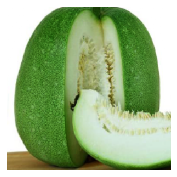

In [39]:
#-------------------------------------------------------
# Below example shows the top 5 predictions for an image
#-------------------------------------------------------
predict_topk_labels(learn,img,labels,5)

> ### Batch Prediction (Predicting multiple images)

In [0]:
#---------------------------------------------
# Build a imagelist specific to testing images
#---------------------------------------------
test_path = 'drive/My Drive/test'
data_test = ImageList.from_folder(test_path)

In [0]:
#--------------------------------------------------------------------------
# Create a learner from the aved model and pass the testing data(Imagelist)
#--------------------------------------------------------------------------
learn = load_learner("/content/drive/My Drive/images", test=data_test)

In [42]:
#----------------------------------------------
# Call get_preds fuction to get the predictions
#----------------------------------------------
preds,y = learn.get_preds(ds_type=DatasetType.Test)

In [43]:
len(preds)

210

In order to calculate top 1, 3, 5 ranked accuracy for testing images, we need 
* Ground tructh/Actual labels
* Predicted labels

In [0]:
#---------------------------------------------------------------
# Groud truth labels need to be extracted from test image names.
# Below fuction returns the test image path in a list
#---------------------------------------------------------------
img_path = []
img_path = get_img_path(test_path)

In [0]:
#------------------------------------------------------------------------------------
# Using regular expression extract the label name from image path. The result will be 
# in format 'carrot.jpg'
#------------------------------------------------------------------------------------
pat = r'([^/\d\_]+)\.jpg$'
actual_category = []
actual_category = get_actual_category(pat,img_path)

In [50]:
len(actual_category)

210

In [0]:
#----------------------------------------------------
#Extract just the label name. i.e. drop the .jpg part
#----------------------------------------------------
actual_label = []
for img in actual_category:
    re = img.split(".",1)[0]
    actual_label.append(re)

In [68]:
#-------------------------------------------------------------------------------------------
# Call the function ranked_accuracy which will retrun rank 1, rank 2 and rank 3 predictions
#-------------------------------------------------------------------------------------------
rank1,rank3,rank5 = ranked_accuracy(preds,labels,actual_label)

starting predictions
top5: ['flat beans', 'snake gourd', 'ash gourd', 'bottle gourd', 'peas']
gt: flat beans
rank5
rank3
rank1
starting predictions
top5: ['flat beans', 'ash gourd', 'chayote', 'snake gourd', 'cabbage']
gt: flat beans
rank5
rank3
rank1
starting predictions
top5: ['flat beans', 'curry leaves', 'peas', 'beans', 'green mango']
gt: flat beans
rank5
rank3
rank1
starting predictions
top5: ['flat beans', 'green mango', 'peas', 'tomato', 'bottle gourd']
gt: flat beans
rank5
rank3
rank1
starting predictions
top5: ['lemon', 'pumpkin', 'onion', 'garlic', 'shallots']
gt: garlic
rank5
starting predictions
top5: ['lemon', 'pumpkin', 'onion', 'garlic', 'ginger']
gt: garlic
rank5
starting predictions
top5: ['onion', 'lemon', 'white raddish', 'plantain flower', 'shallots']
gt: garlic
starting predictions
top5: ['garlic', 'pumpkin', 'onion', 'chayote', 'white onion']
gt: garlic
rank5
rank3
rank1
starting predictions
top5: ['onion', 'lemon', 'pumpkin', 'white onion', 'garlic']
gt: garlic


In [69]:
#-----------------------------------------------------------------
# Rank 1, Rank 3 and Rank 5 accuracy of testing data in percentage
#-----------------------------------------------------------------
rank1*100,rank3*100,rank5*100

(71.9047619047619, 86.66666666666667, 93.33333333333333)

<hr>

# <div align='center'> Supporting functions</div>









> ### Function to train a model



In [0]:
def train(learner,epoch=4,maxlr=0.003):
    learn = learner
    learn.fit_one_cycle(epoch,maxlr)



> ### Function to interpret the results



In [0]:
def interpret_results(learn):
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(figsize = (15,15))
    interp.plot_top_losses(20,figsize=(35,15))
    



> ### Function to calculate accuracy by category


In [0]:
def accuracy_by_category():
    interp = ClassificationInterpretation.from_learner(learn)
    cat = interp.confusion_matrix()
    actual_category = []
    total_correct = []
    total = []
    accuracy = []
    labels = learn.data.c2i

    for i in range(len(cat)):
        #print(i) 
        #print(cat[i][i])
        #print(sum(cat[i]))
        #cat_acc = cat[i][i]/sum(cat[i]) * 100
        #print(round(cat[i][i]/sum(cat[i]) * 100,2 ))
        actual_category.append(i)
        total_correct.append(cat[i][i])
        total.append(sum(cat[i]))
        accuracy.append(round(cat[i][i]/sum(cat[i]) * 100,2))
    
    d = {"class":list(labels.keys()),"total_correct":total_correct,"total":total,"accuracy":accuracy}
    df = pd.DataFrame(d)
    return(df)



> ### Function to predict top k categories/classes


In [0]:
def predict_topk_labels(learn,img,labels,k):
    img.resize(299)
    img.show()
    pred_class,pred_idx,outputs = learn.predict(img)
    top5 = torch.topk(outputs,k)
    key_list = list(labels.keys())
    val_list = list(labels.values())
    for i in range(len(top5[1])):
        print(key_list[val_list.index(top5[1][i])])

> ### Function to calculate top k accuracy for testing data


In [0]:
def ranked_accuracy(preds,labels,actual_label):
    rank1=0
    rank3=0
    rank5=0
    

    for (pred,gt) in zip(preds,actual_label):
        top5 = []
        print("starting predictions")
        p = np.argsort(-pred)
        key_list = list(labels.keys())
        val_list = list(labels.values())
        for i in range(len(p[:5])):
            #print(key_list[val_list.index(p[i])])
            top5.append(key_list[val_list.index(p[i])])

        #print("p:",p)
        print("top5:",top5)
        #print(len(p))
        #print("top 5 preds:", p[:5])
        print("gt:",gt)

        if gt in top5[:5]:
              print("rank5")
              rank5 += 1
        
        if gt in top5[:3]:
              print("rank3")
              rank3 += 1

        if gt in top5[:1]:
              print("rank1")
              rank1 +=1
        #print("rank1: ",rank1)
        #print("rank3: ",rank3)
        #print("rank5: ",rank5)
    rank1 /= float(len(preds))
    rank3 /= float(len(preds))
    rank5 /= float(len(preds))
    #print(len(preds))
    return(rank1,rank3,rank5)

> ### Function to get the test images path in a list

In [0]:
def get_img_path(path):
    #print(path)
    actual_img_path = []
    valid_images = [".jpg",".gif",".png",".tga"]
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        actual_img_path.append(os.path.join(path,f))
        #print(actual_img_path)
    return(actual_img_path)

> ### Function to get extract the image name from the list of images path

In [0]:
def get_actual_category(pat,img_path):
    category = []
    for imgpath in img_path:
        #print(imgpath)
        result = re.search(pat,imgpath)
        #print(result)
        category.append(result.group())
    return(category)